# Practice 6: Demand I - Evidence

In this lecture, we talked about measuring the response to different demand-side policies.

We will compare different dynamic pricing programs by replicating some of the results in 
- "Estimating the Elasticity to Real Time Pricing," by Fabra, Rapson, Reguant and Wang; 
- "Measuring the Impact of Time-of-Use Pricing on Electricity Consumption: Evidence from Spain" by Enrich, Li, Mizraghi and Reguant


We load packages and set the dirpath.

In [1]:
begin
    using DataFrames
    using Statistics
    using CSV
    using Binscatters
    using FixedEffectModels
    using StatsPlots
    using Dates
end

In [6]:
dirpath = "/Users/marreguant/Documents/GitHub/phd-energy/materials/bonus/"

"/Users/marreguant/Documents/GitHub/phd-energy/materials/bonus/"

## Real-time Pricing (RTP)
### Data exploration

Loading **data**. 

* data\_rtp.csv: Smart meter data of a small sample of 40 consumers. 
We will use **kwh** (hourly electricity consumption in mwh) as our dependent variable.

The data is already merged with several other hourly data that can be either 

Consumer specific:
- temp, temp2: temperature 
- rtp / tou: whether consumers are under rtp pricing (for the energy cost) and tou pricing (for the charges component, more on that in the second part) 

Market specific:
- price: price of a mwh of electricity
- wind_hat: wind forecast
- solar_actual: solar production
- mwh_dayaheadiberia: demand forecast

Time variables:
- y: year
- m: month
- hr: hour

In [8]:
begin
    mydata = CSV.read(string(dirpath,"data_rtp.csv"), DataFrame)
    mydata = dropmissing(mydata)
    first(mydata, 5)
end

Row,id,rtp,tou,date,y,m,dom,hr,wk,dow,weekend,kwh,price,wind_hat,solar_actual,temp,temp2,mwh_dayaheadiberia
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Float64,Int64,Int64,Float64
1,8,1,0,20563,2016,4,19,2,16,2,0,0.074,0.06358,8950,108.667,60,3600,22749.4
2,8,1,0,20563,2016,4,19,3,16,2,0,0.059,0.06356,9179,101.5,58,3364,21948.7
3,8,1,0,20563,2016,4,19,4,16,2,0,0.009,0.06563,8486,87.3333,53,2809,21109.4
4,8,1,0,20563,2016,4,19,5,16,2,0,0.134,0.06974,8615,87.0,53,2809,20930.5
5,8,1,0,20563,2016,4,19,6,16,2,0,0.069,0.08423,8708,62.3333,54,2916,21265.8


In [21]:
mean(mydata.price)

0.10705517167341204

In [4]:
describe(mydata)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,id,3395.14,8,3733.0,7057,0,Int64
2,rtp,0.520608,0,1.0,1,0,Int64
3,tou,0.0,0,0.0,0,0,Int64
4,date,20708.6,20454,20703.0,20982,0,Int64
5,y,2016.31,2016,2016.0,2017,0,Int64
6,m,5.21937,1,4.0,11,0,Int64
7,hr,12.5732,1,13.0,24,0,Int64
8,weekend,0.29027,0,0.0,1,0,Int64
9,kwh,0.278662,0.0,0.148,5.142,0,Float64


It can be useful to plot the data to examine patterns. We can plot the typical consumption pattern of consumers during the day.

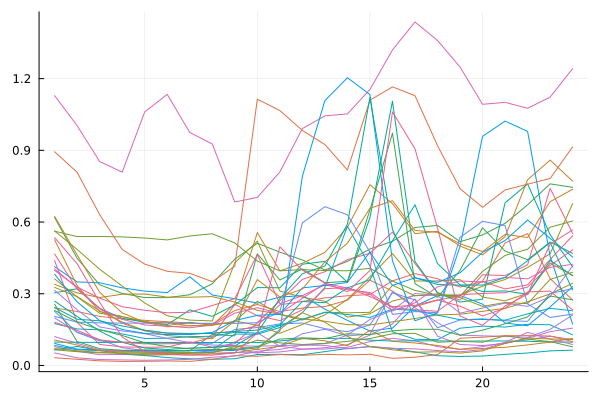

In [5]:
let
    # here we can learn about ways of collapsing data in Julia
    # lots going on here! see suggested exercise below
    
    df_plt = select(mydata,[:id,:hr,:kwh])
    df_plt = combine(groupby(df_plt, [:id,:hr]), :kwh => mean)
    sort!(df_plt,[:id,:hr])
    plot(df_plt.hr, df_plt.kwh_mean, group=df_plt.id, legend=false)

end

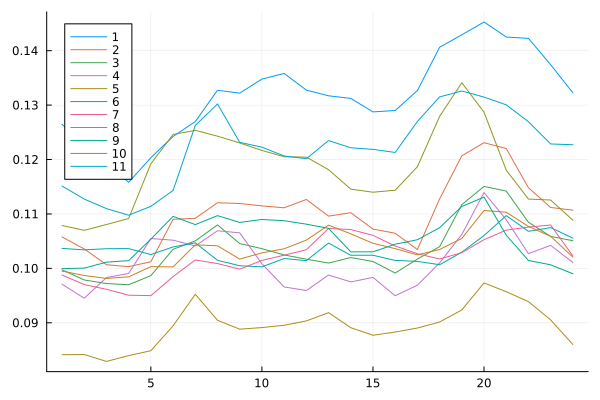

In [6]:
let
    # we can also plot prices
    df_plt = select(mydata,[:hr,:price, :m])
    df_plt = combine(groupby(df_plt, [:hr,:m]), :price => median)
    sort!(df_plt,[:m,:hr])
    plot(df_plt.hr, df_plt.price_median, group=df_plt.m)
    
end

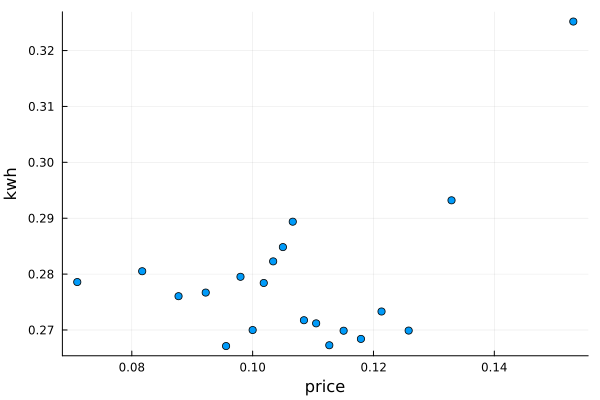

In [9]:
let
    # we can plot the raw correlation of consumption and prices
    # interesting that not particularly correlated with price 
    binscatter(mydata,  @formula(kwh ~ price))
end

In [11]:
reg1 =  reg(mydata, @formula(kwh ~ price + fe(id)))  # reverse causality!

                          FixedEffectModel                          
Number of obs:             380063  Converged:                   true
dof (model):                    1  dof (residuals):           380023
R²:                         0.279  R² adjusted:                0.279
F-statistic:                162.6  P-value:                    0.000
R² within:                  0.000  Iterations:                     1
       Estimate  Std. Error   t-stat  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────
price  0.367714    0.028837  12.7515    <1e-36   0.311195   0.424234


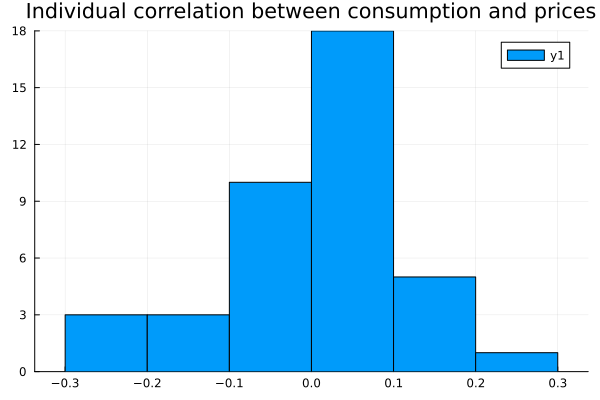

In [12]:
let
    # let's look at individual correlations
    ids = unique(mydata.id);
    corrs = [cor(mydata[mydata.id.==i,:].price,
                mydata[mydata.id.==i,:].kwh) for i in ids];
    histogram(corrs, title="Individual correlation between consumption and prices")
end

### Estimation of elasticities

We will be running a regression for each consumer in our sample, instrumenting price with wind forecast and obtaining a distribution of elasticities.

In [13]:
length(unique(mydata.id))

40

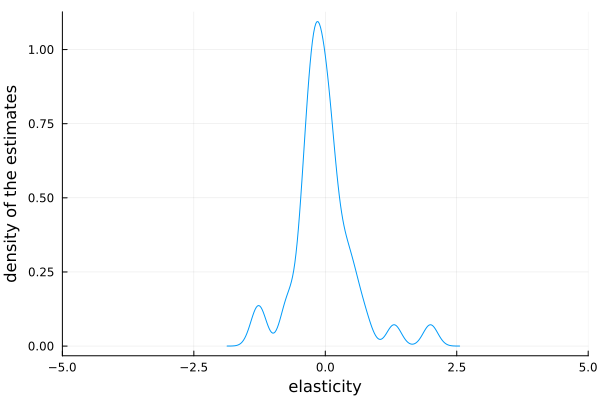

In [9]:
begin

    # We store the estimates for each individual
    betas = DataFrame(beta=Float64[], rtp=Float64[])
    for i in 1:length(unique(mydata.id))

        dataid = mydata[mydata.id .== unique(mydata.id)[i], :];

        reg_fe = reg(dataid,
            @formula(log(kwh +  1.0/100.0) ~ (log(price + 1/100) ~ wind_hat)
            + fe(hr)*fe(m) + fe(y) + fe(weekend)*fe(hr) 
            + solar_actual + temp + temp2 + mwh_dayaheadiberia
                                            ))
        beta = coef(reg_fe)[coefnames(reg_fe) .=="log(price + 1 / 100)"][1];
        rtp  = mean(dataid.rtp);
        push!(betas,[beta,rtp]);

    end

    # We plot the estimates
    density(betas.beta, legend = false)
    plot!(xlab="elasticity",ylab="density of the estimates",xlim=(-5,5))

end

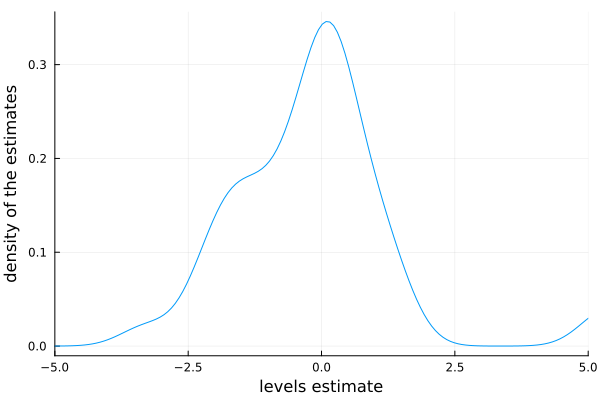

In [25]:
begin

    # We store the estimates for each individual
    betas_levels = DataFrame(beta=Float64[], rtp=Float64[])
    for i in 1:length(unique(mydata.id))

        dataid = mydata[mydata.id .== unique(mydata.id)[i], :];

        reg_fe = reg(dataid,
            @formula(kwh ~ (price ~ wind_hat)
            + fe(hr)*fe(m) + fe(y) + fe(weekend)*fe(hr) 
            + solar_actual + temp + temp2 + mwh_dayaheadiberia
                                            ))
        beta = coef(reg_fe)[coefnames(reg_fe) .=="price"][1];
        rtp  = mean(dataid.rtp);
        push!(betas_levels,[beta,rtp]);

    end

    # We plot the estimates
    density(betas_levels.beta, legend = false)
    plot!(xlab="levels estimate",ylab="density of the estimates",xlim=(-5,5))

end

### Follow-up exercises


1. Split the data between households with and without RTP (defined by the rtp variable) and check whether consumers under RTP have different price elasticities. 


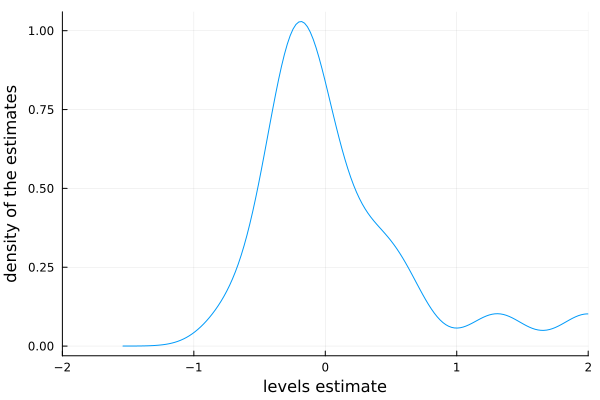

In [31]:
# We plot the estimates
density(betas.beta[betas.rtp.==0], legend = false)
plot!(xlab="levels estimate",ylab="density of the estimates",xlim=(-2,2))

## 2. Time-of-Use (TOU)

### Data

Loading data.

- df_tou.csv: time series with hourly data at distribution level

In [14]:
begin
    df_tou = CSV.read(string(dirpath,"df_tou.csv"), DataFrame)

    #we convert tou tariffs to string
    # we add "; nothing" if we do not want the output displayed

    df_tou.tou = string.(df_tou.tou); nothing
    df_tou.tou_allweek = string.(df_tou.tou_allweek); nothing
end

**Description of variables**

Time variables:
- date, hour, year, month 
- month_count: month of sample 
- week, week_c: dummy variables indicating whether the observation falls into a weekday or a weekend

Identifier:
- dist: distribution area

Policy variables:
- policy: takes 1 for all distribution areas in Spain after the introduction of the policy
- placebo: takes 1 for all distribution areas in Spain one month before the introduction of the policy
- tou: TOU tariffs, split between **Off-peak, Mid-Peak, and Peak hours**
- tou_allweek: TOU tariffs but artificially differentiating hours during the weekend (even though all hours had the same electricity price).

Controls:
- temperature: temp, temph (whether the temperature is above 20ºC)

Prices:
- charges: charges component of the electricity price, affected by TOU tariffs
- total_price: charges + energy cost

Outcomes:
- demand: demand (in mwh) at the distribution level
- consumer: number of consumers at the distribution level
- demand_pc (in kwh): demand / consumers 

In [11]:
describe(df_tou)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,date,,2018-01-01,,2021-09-14,0,Date
2,hour,12.5007,1,13.0,24,0,Int64
3,dist,,EDP,,REPSOL,0,String15
4,year,2019.38,2018,2019.0,2021,0,Int64
5,month,6.18894,1,6.0,12,0,Int64
6,country,,ES,,PT,0,String3
7,tou,,1,,3,0,String
8,tou_allweek,,1,,3,0,String
9,month_count,22.7516,1,23.0,45,0,Int64


In [17]:
unique(df_tou.dist)

6-element Vector{String15}:
 "EDP"
 "ENDESA"
 "IBERDROLA"
 "NATURGY"
 "REPSOL"
 "PT_reg"

A significant change in the design of the tariffs was introduced on **June 1, 2021**. The policy change introduced mandatory TOU pricing, with the charges component of the electricity price having **three different tiers**, depending on the hour of the day and the day of the week.

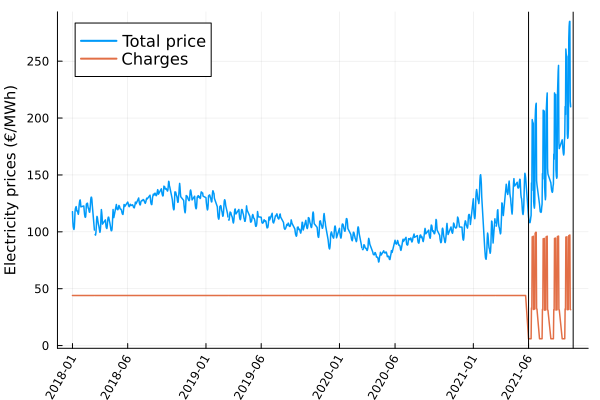

In [12]:
let
    
    df_month = filter(row->row.country == "ES",df_tou)
    
    #We compute the average monthly price for each hour of the day
    df_month = combine(groupby(df_month,[:year,:month, :hour]), 
                            [:demand,:total_price, :charges] => ((d, p, c) ->
                            (total_price = (sum(p.* d) / sum(d)),
                            charges = (sum(c.* d) / sum(d)))) => [:total_price, :charges]
    )

    df_month.date = Date.(df_month.year,df_month.month,df_month.hour)

    prices_plot=plot(df_month.date, df_month.total_price,linewidth=1.5,label="Total price")
    plot!(df_month.date, df_month.charges,linewidth=1.5,label="Charges") 
    plot!(xticks = ([Date(2018,1,01),Date(2018,06,01),Date(2019,1,1),Date(2019,06,01),Date(2020,01,01),Date(2020,06,01),Date(2021,01,01),Date(2021,06,01)],
            ["2018-01","2018-06","2019-01","2019-06","2020-01","2020-06","2021-01","2021-06"]),
            yticks=([0,50,100,150,200,250],["0","50","100","150","200","250"]),
             xrotation = 60,
             ylabel = "Electricity prices (€/MWh)",  yguidefontsize = 10,
             legend=:topleft,legendfontsize=11)
    plot!([Date(2021,06,01),Date(2021,10,01)], seriestype="vline",color=:black,label="")

end

### Differences-in-differences

To identify the potential demand response to the policy, we will estimate a **DiD model**, where our policy variable equals one for all Spanish distribution areas after the policy was implemented.

Moreover, we will identify an effect for each of the TOU tariffs: **Off-peak, Mid-Peak, and Peak hours**.

In [15]:
begin

    # We drop the observations for 2020 due to the disruption of COVID-19
    years_out = 2020 
    df_reg = filter(!(row->row.year in years_out), df_tou)

    model_did=  reg(df_reg, @formula(log_demand_pc ~ 
         # policy
         policy & tou 
         # placebo
         + placebo & tou  
         + temp*temph +
         fe(dist)*fe(month)*fe(hour)*fe(tou) + fe(dist)*fe(year)*fe(tou)*fe(hour) 
         + fe(month_count)*fe(tou)*fe(hour) ), weights = :consumer,
         Vcov.cluster(:dist,:month)
    )
    
end

Demean Variables: [=============================>   ]  9/10

┌ Warning: estimated covariance matrix of moment conditions not positive-semidefinite.
│                 adjustment from Cameron, Gelbach & Miller (2011, JBES) applied.
│                  model tests should be interpreted with caution.
└ @ Vcov /Users/marreguant/.julia/packages/Vcov/MUQ52/src/utils.jl:5


                                     FixedEffectModel                                     
Number of obs:                        142000  Converged:                              true
dof (model):                               9  dof (residuals):                           5
R²:                                    0.954  R² adjusted:                           0.951
F-statistic:                     -4.98141e17  P-value:                               1.000
R² within:                             0.157  Iterations:                               30
                     Estimate  Std. Error       t-stat  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
temp              -0.0132877   0.00343864  -3.86424       0.0118  -0.0221271   -0.00444843
temph             -0.547598    0.16228     -3.37441       0.0198  -0.964752    -0.130445
policy & tou: 1    9.98636e-5  0.0364608    0.00273893    0.9979  -0.0936257    0.0938254
po

However, when comparing these different pricing regimes, we combine off-peak hours during the day with all hours during the weekend. Thus, given that part of the consumption cannot be shifted between days, we next split the effect by differentiating between weekdays and weekends.

We now use **tou_allweek** in the regression, which differentiates TOU tariffs during the weekend even though all hours had the same electricity price.

In [14]:
begin 

    model_td = reg(df_reg, @formula(log_demand_pc ~ 
         # policy 
         policy & week_c & tou_allweek 
         # placebo 
         + placebo & week_c & tou_allweek 
         + temp*temph 
         + fe(dist)*fe(month)*fe(hour)*fe(tou_allweek)*fe(week) 
         + fe(dist)*fe(year)*fe(tou_allweek)*fe(week)*fe(hour) 
         + fe(month_count)*fe(tou_allweek)*fe(week)*fe(hour) 
         ), weights = :consumer,
         Vcov.cluster(:dist,:month)
    )

end

Demean Variables: [================================>]  16/16

┌ Warning: estimated covariance matrix of moment conditions not of full rank.
│                  model tests should be interpreted with caution.
└ @ Vcov ~/.julia/packages/Vcov/DtD53/src/utils.jl:5


                                             Fixed Effect Model                                             
Number of obs:                                 142000  Degrees of freedom:                                14
R2:                                             0.960  R2 Adjusted:                                    0.960
F-Stat:                                    3.58631e15  p-value:                                        0.000
R2 within:                                      0.175  Iterations:                                        30
log_demand_pc                              |   Estimate  Std.Error   t value Pr(>|t|)   Lower 95%  Upper 95%
------------------------------------------------------------------------------------------------------------
temp                                       | -0.0133703  0.0244326 -0.547231    0.608  -0.0761763  0.0494357
temph                                      |   -0.54798   0.063964    -8.567    0.000   -0.712404  -0.383555
temp & temph       

**Weekday effects:**

The following coefficients represent, for different TOU hours, the average change in consumption during a weekday with respect to the same hours before the policy was implemented.


In [32]:
let

    #we can access particular features of our regression model
    coef_names = coefnames(model_td)[occursin.("policy & week_c: week ", coefnames(model_td))] 

    coef_value= coef(model_td)[occursin.("policy & week_c: week ", coefnames(model_td))]

    coef_se = stderror(model_td)[occursin.("policy & week_c: week ", coefnames(model_td))]

    #We select a subset of characters   
    coef_names = last.(coef_names,21)

    #Create a Daframe with relevant coefficients
    coef_week = DataFrame([coef_names coef_value coef_se], 
                           [:Name,:Coefficient,:Standard_error])

end

Row,Name,Coefficient,Standard_error
,Any,Any,Any
1,week & tou_allweek: 1,0.0368523,0.0343037
2,week & tou_allweek: 2,-0.053893,0.00986589
3,week & tou_allweek: 3,-0.101222,0.0219375


Note that the coefficients for Mid-Peak and Peak hours are similar to those in the DiD model, while now the Off-Peak coefficient has turned positive.

**Weekend effects:**

The following coefficients represent, for different TOU hours, the average change in consumption during weekends with respect to the same hours before the policy was implemented.

In [33]:
let

    coef_names = coefnames(model_td)[occursin.("policy & week_c: weekend", coefnames(model_td))] 

    coef_value= coef(model_td)[occursin.("policy & week_c: weekend", coefnames(model_td))]

    coef_se = stderror(model_td)[occursin.("policy & week_c: weekend", coefnames(model_td))]

    #We select a subset of characters   
    coef_names = last.(coef_names,24)

    #Create a Daframe with relevant coefficients   
    coef_weekend = DataFrame([coef_names coef_value coef_se], 
                           [:Name,:Coefficient,:Standard_error])
 
 end

Row,Name,Coefficient,Standard_error
,Any,Any,Any
1,weekend & tou_allweek: 1,0.0321249,0.0366422
2,weekend & tou_allweek: 2,-0.0526441,0.0258471
3,weekend & tou_allweek: 3,-0.074634,0.0759032


Even though under the new TOU tariffs, weekend consumption is subject to off-peak prices, we observe a significant demand response for all three periods in some specifications. 

These results point to some sort of  habit formation.
